In [1]:
import scipy.io as sci
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from datetime import datetime

In [2]:
# 文件载入
# fileDrive = r'C:\Users\mikel\Desktop\Guosheng\Daily'
fileDrive = r'C:\Users\mikel\Desktop\Guosheng\Daily'
openPriceF = sci.loadmat(fileDrive+'\AllStock_DailyOpen_dividend.mat')
closePriceF = sci.loadmat(fileDrive+'\AllStock_DailyClose_dividend.mat')
listedDaysF = sci.loadmat(fileDrive+'\AllStock_DailyListedDate.mat')
stF = sci.loadmat(fileDrive+'\AllStock_DailyST.mat')
dailyStatusF = sci.loadmat(fileDrive+'\AllStock_DailyStatus.mat')
tradingDateF = sci.loadmat(fileDrive + '\TradingDate_Daily.mat')
stockCodeF = sci.loadmat(fileDrive + '\AllStockCode.mat')
zz500 = pd.read_excel(r'C:\Users\mikel\Desktop\Guosheng\指数成分股 300&500.xlsx',sheet_name='中证500',header = 0)
minuteInfoF = sci.loadmat(r'C:\Users\mikel\Desktop\data\UnAdjstedStockMinute_000001.mat')
# 导入文件中的数据到np array
openPrice = openPriceF['AllStock_DailyOpen_dividend']
closePrice = closePriceF['AllStock_DailyClose_dividend']
listedDays = listedDaysF['AllStock_DailyListedDate']
stStatus = stF['AllStock_DailyST']
dailyStatus = dailyStatusF['AllStock_DailyStatus_use']
tradingDate = tradingDateF['TradingDate_Daily']
stockCode =  stockCodeF['AllStockCode']
minuteInfo = minuteInfoF['UnAdjstedStockMinute_000001']

In [3]:
print(minuteInfo[0][0])

20130326.0


In [4]:
# 样本大小
stocks = openPrice.shape[1]   # 4952 stocks
days = openPrice.shape[0]
startDay = 2240
endDay = 3407
validDays = endDay - startDay

In [12]:
# 挑出要选的样本,用表isValid作标记
isValid = np.zeros((validDays,stocks))
for i in range(startDay,endDay):
    for j in range(stocks):
        if listedDays[i][j] > 60 and stStatus[i][j] == 0 and dailyStatus[i-1][j] == 1 and dailyStatus[i][j] == 1 and openPrice[i][j] < closePrice[i-1][j]:
            isValid[i-startDay][j] = 1
        else: 
            isValid[i - startDay][j] = 0

In [19]:
print(isValid.shape)

(1167, 4952)


In [13]:
# 辅助函数，用于计算值X在数组V中的排序位置
def percentile_rank(x,v):
    return (v <= x).sum() / len(v)

In [14]:
# 辅助函数，计算P
def calculateP(dayIndex):
    volumeArray = np.zeros(60)
    for i in range(dayIndex - 61,dayIndex - 1):
        volumeArray[i - dayIndex + 61] = minuteInfo[(i - startDay) * 242 + 1][5]
    return percentile_rank(minuteInfo[(dayIndex- startDay) * 242][5],volumeArray)

In [29]:
# 计算集合竞价，归入相应组别,存于表volumeP中
volumeP = np.zeros(validDays)
sampleList = []
for i in range(startDay + 60,endDay):
    if isValid[i - startDay][0] == 1:
sampleArray = np.array(sampleList)
for i in range(startDay + 60,endDay):
    percentile = percentile_rank(calculateP(i),sampleArray)
    print(percentile)
    if isValid[i - startDay][0] == 1:
        if percentile != 1:
            volumeP[i - startDay] = percentile * 100 // 10 + 1
        else:
            volumeP[i - startDay] = 10

0.8776978417266187
0.6438848920863309
0.6438848920863309
0.5377697841726619
0.6438848920863309
0.7302158273381295
0.6672661870503597
0.42805755395683454
0.25719424460431656
0.9748201438848921
1.0
0.8848920863309353
0.6672661870503597
0.5035971223021583
0.6133093525179856
0.5035971223021583
0.8525179856115108
0.25719424460431656
0.8776978417266187
0.5035971223021583
0.4550359712230216
0.8597122302158273
0.1366906474820144
0.5035971223021583
0.210431654676259
0.7949640287769785
0.210431654676259
0.3920863309352518
0.25719424460431656
0.25719424460431656
0.1366906474820144
0.42805755395683454
0.6438848920863309
0.6438848920863309
0.210431654676259
0.8327338129496403
0.9640287769784173
0.6438848920863309
0.6672661870503597
0.1366906474820144
0.8399280575539568
0.6133093525179856
0.4550359712230216
0.4550359712230216
0.5377697841726619
0.29676258992805754
0.3255395683453237
0.25719424460431656
0.48201438848920863
0.1366906474820144
0.1366906474820144
0.9100719424460432
0.9910071942446043
0.

In [27]:
print(volumeP[100:200])

[ 0.  7.  5.  0.  6.  0.  0.  3.  0.  0.  0.  0. 10. 10.  4.  0.  7.  5.
  0.  2.  2.  2.  2.  0.  0.  4.  0.  0.  2.  0.  2.  0.  0.  0.  2.  0.
  0.  9.  8.  0.  3.  9.  8.  0.  5.  7.  0.  5.  0.  0.  3.  7.  0.  0.
 10.  0.  4.  4.  3.  0.  2.  0.  0.  0.  5.  4.  3.  0.  0.  0.  2.  3.
  3.  7.  0.  2.  0.  0.  0.  0.  0.  4.  0.  0.  7.  5.  5.  4.  5.  0.
  2.  2.  2.  4.  2.  2.  2.  0.  0.  0.]


In [24]:
# 计算所选样本当日回报率
returnArray = np.zeros((10,validDays))   # 记录每一天每个组别回报率累计
counter = np.zeros((10,validDays))     # 记录每一天每个组别样本数
lowPriceF = sci.loadmat(fileDrive+'\AllStock_DailyLow_dividend.mat')
lowPrice = lowPriceF['AllStock_DailyLow_dividend']
for i in range(startDay,endDay): 
    if isValid[i -startDay][0] == 1:
        if lowPrice[i][0]/closePrice[i-1][0] - 1 < -0.098:
            returnRate = lowPrice[i][0]/openPrice[i][0] - 1
        else:
            returnRate = closePrice[i][0]/openPrice[i][0] - 1
        returnArray[int(volumeP[i - startDay]) - 1][i - startDay] = returnArray[int(volumeP[i - startDay]) - 1][i- startDay] + returnRate
        counter[int(volumeP[i - startDay]) - 1][i - startDay] = counter[int(volumeP[i - startDay]) - 1][i - startDay] + 1

dailyAverageReturn = np.zeros([10,validDays])
for i in range(10):
    for j in range (validDays):
        if counter[i][j] != 0:
            dailyAverageReturn[i][j] = returnArray[i][j] / counter[i][j]

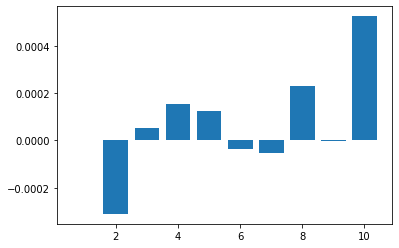

In [25]:
averageReturn = np.average(dailyAverageReturn, axis=1) 
plt.bar(range(1,len(averageReturn)+1), averageReturn)
plt.show()